In [1]:
from pathlib import Path
import numpy as np
import supervision as sv
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
PATH_MAT = Path("./material")
PATH_IMGS = PATH_MAT / "images"
PATH_TEMPLATE = PATH_MAT / "template" / "pattern.png"

# Testing preliminar sobre imagen ejemplo

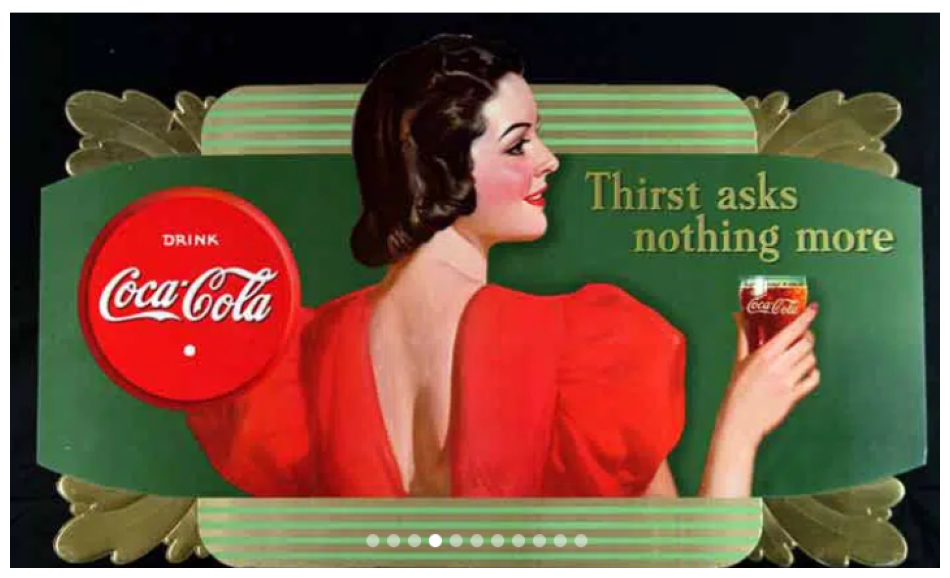

In [3]:
# levantamos una imagen ejemplo
fname = 'coca_retro_2.png'

sample_img = cv.imread(PATH_IMGS / fname)
sv.plot_image(sample_img)

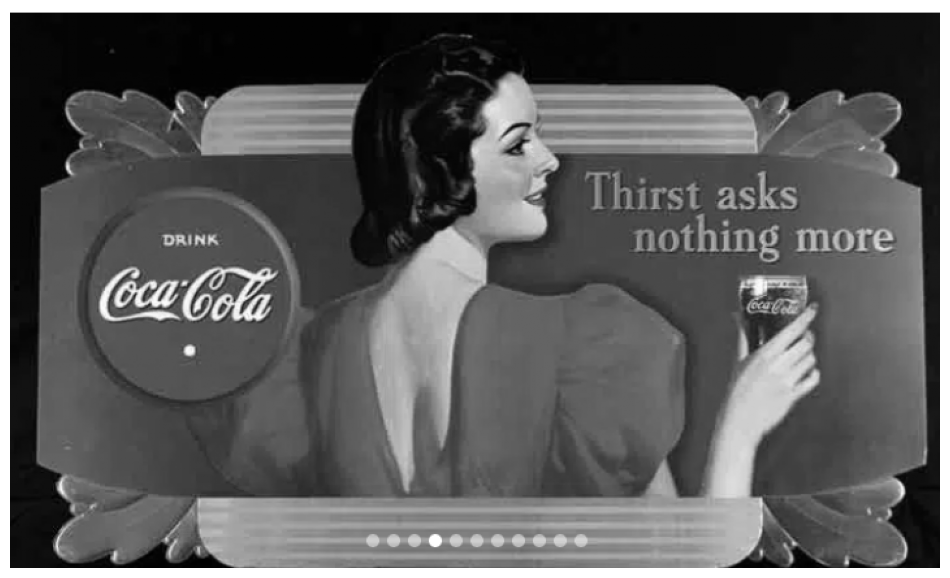

In [4]:
# pasamos a grayscale
sample_img_gs = cv.cvtColor(sample_img, cv.COLOR_BGR2GRAY)
sv.plot_image(sample_img_gs)

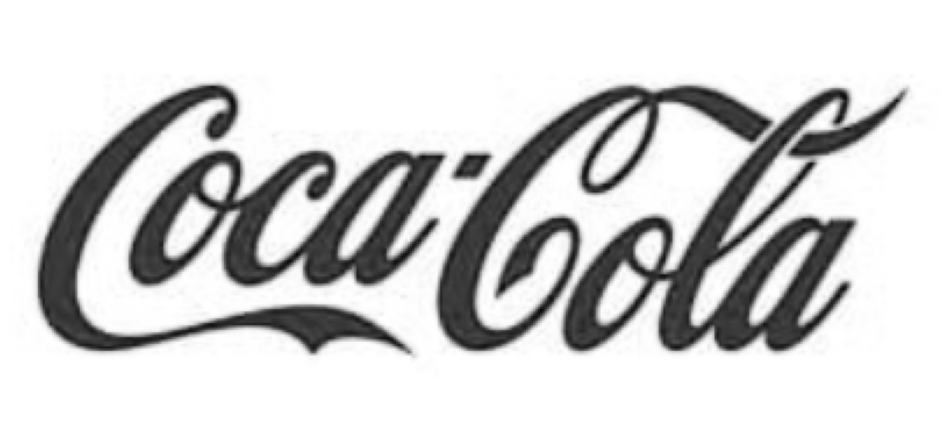

In [5]:
# mostramos el template
template = cv.imread(PATH_TEMPLATE, cv.IMREAD_GRAYSCALE)

sv.plot_image(template)

Una verificación rápida permite observar que en el template son letras negras sobre fondo blanco, mientras que en la imagen original ambas instancias del logo son letras blancas sobre fondo oscuro. Es muy probable que esto resulte en un problema.

In [7]:
# determinamos todos los matches usando un threshold
method = cv.TM_SQDIFF_NORMED
threshold = 0.55
MIN_BEST_METHODS = {cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED}
cmp = lambda x,t,m: (x<=t) if m in MIN_BEST_METHODS else (x >= t)

res = cv.matchTemplate(sample_img_gs, template, method)
mask = cmp(res, threshold, method)
ys, xs = np.where(mask)

scores = res[mask].flatten()

len(scores), list(zip(xs,ys))[:5]

(285,
 [(np.int64(184), np.int64(245)),
  (np.int64(185), np.int64(245)),
  (np.int64(186), np.int64(245)),
  (np.int64(187), np.int64(245)),
  (np.int64(188), np.int64(245))])

In [8]:
# utils
def plot_boxes(xy: tuple[np.ndarray,np.ndarray], template: np.ndarray, base_img: np.ndarray):
    img_copy = base_img.copy()
    h,w = template.shape

    for x,y in zip(*xy):
        cv.rectangle(img_copy, (x,y), (x+w,y+h), (0,0,255), 2)

    sv.plot_image(img_copy)

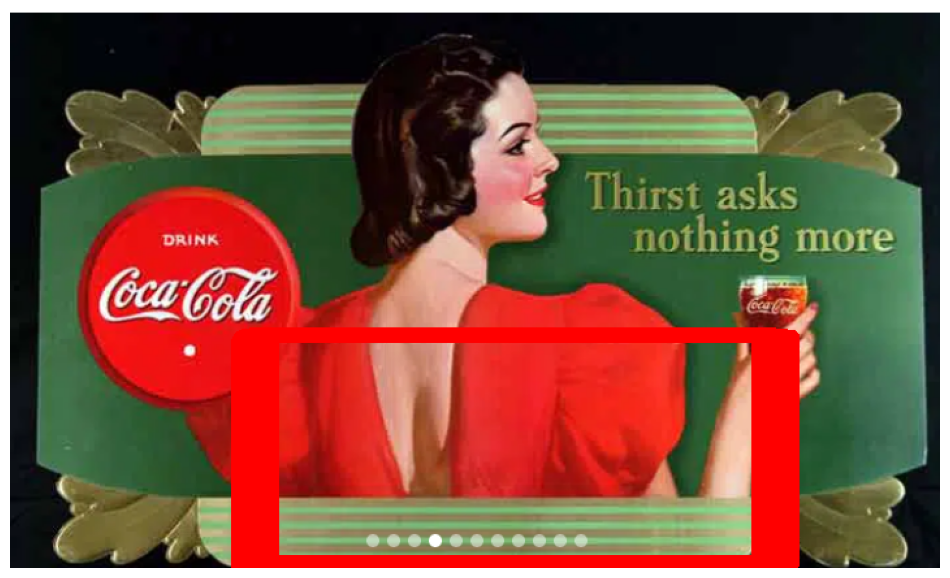

In [9]:
# mostramos
plot_boxes((xs,ys), template, sample_img)

Hay muchos rectángulos que están básicamente sobre la misma región, es decir con muy alto IoU. Aplicamos _Non-Maximum Suppression_ sobre IoUs exageradamente altos.

In [10]:
# ordenamos por score según el método
rank = np.argsort(scores)

if method not in MIN_BEST_METHODS:
    # best is highest instead
    rank = rank[::-1]

rank[:10]

array([231, 232, 230, 233, 229, 234, 265, 228, 264, 266])

In [11]:
# aplicamos orden
xs_sorted = xs[rank]
ys_sorted = ys[rank]

In [13]:
# box iou entre el primero y un par
dx = np.abs(xs_sorted[1:5]-xs_sorted[0])
dy = np.abs(ys_sorted[1:5]-ys_sorted[0])
h, w = template.shape

area_int = np.maximum(w - dx, 0) * np.maximum(h - dy, 0)

# el area de ambos es w*h
area_union = 2 * w * h - area_int

area_int/area_union

array([0.99501247, 0.99501247, 0.99004975, 0.99004975])

In [55]:
def nms(x: np.ndarray, y: np.ndarray, template: np.ndarray, min_iou: float) -> np.ndarray:
    """Apply Non-Maximum Suppression to (x,y) vertices of all same (w,h) rectangles.

    Args:
        x (np.ndarray): array with x coordinate of vertices, shape (N,).
        y (np.ndarray): array with y coordinate of vertices, shape (N,).
        template (np.ndarray): array with shape (h,w).
        min_iou (float): threshold above which two rectangles will be considered to match.

    Returns:
        np.ndarray: indices of kept vertices
    """
    h,w = template.shape

    # discard-first style
    candidates = np.arange(x.shape[0])
    keep = []

    while candidates.size:
        # first remaining box is kept
        anchor_idx = candidates[0]
        keep.append(anchor_idx)

        # compare against the rest
        rest = candidates[1:]
        if rest.size == 0:
            break

        # compute overlap in x and y
        dx = np.abs(x[rest] - x[anchor_idx])
        dy = np.abs(y[rest] - y[anchor_idx])

        # areas
        area_int = np.maximum(w - dx, 0) * np.maximum(h - dy, 0)
        area_union = 2 * w * h - area_int

        # compute IoU where union area is > 0
        iou = np.zeros_like(area_int, dtype=float)
        valid = area_union > 0
        iou[valid] = area_int[valid] / area_union[valid]

        # discard everything above threshold
        candidates = rest[iou <= min_iou]
    
    return np.array(keep, dtype=int)

In [ ]:
# aplicamos NMS con threshold muy alto
nms_kept = nms(
    x=xs_sorted,
    y=ys_sorted,
    template=template,
    min_iou=0.7
)

len(nms_kept)

1

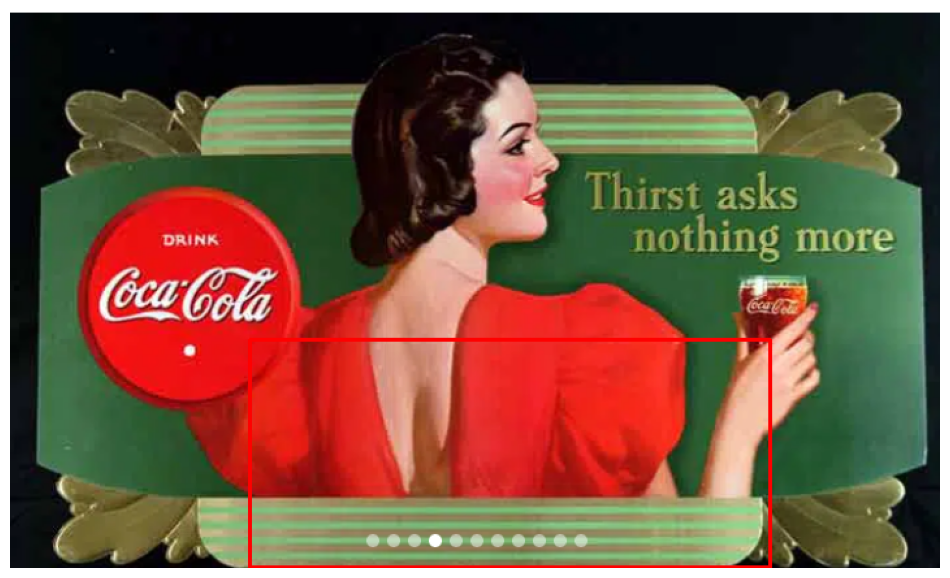

In [17]:
# volvemos a plotear
plot_boxes(
    (xs_sorted[nms_kept], ys_sorted[nms_kept]),
    template,
    sample_img
)

Ahora se logró reducir el tamaño de las detecciones, pero la misma no es buena.
Como se puede apreciar, el problema es que _Template Matching_ asume que el tamaño de la imagen _template_ es el mismo en la imagen sobre la que se busca. Para paliar este problema se aplican pirámides.

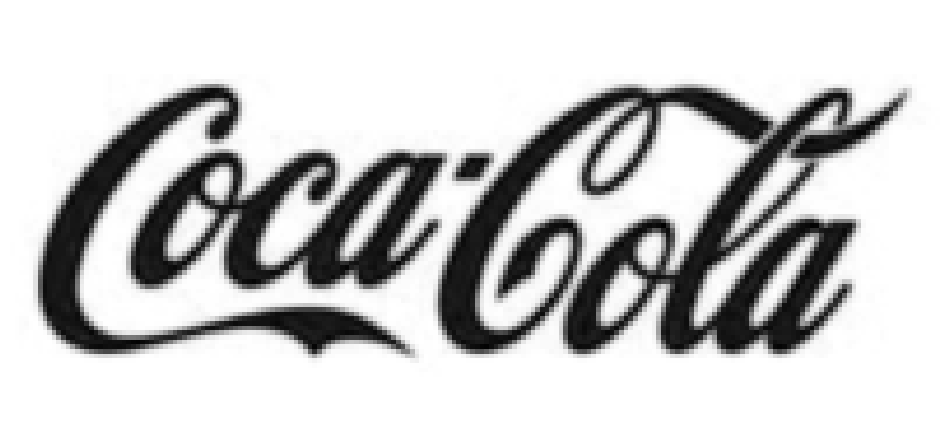

In [18]:
# ejemplo de aplicación de 1 downscaling por pirámide Gaussiana
template_ds2 = cv.pyrDown(template)
h2, w2 = template_ds2.shape

sv.plot_image(template_ds2)

In [19]:
# comparamos shapes
[x.shape for x in (template, template_ds2)]

[(175, 400), (88, 200)]

In [ ]:
# repetimos las detecciones y aplicamos NMS
res = cv.matchTemplate(sample_img_gs, template_ds2, method)
mask = cmp(res, threshold, method)
ys, xs = np.where(mask)

scores = res[mask].flatten()

rank = np.argsort(scores)

if method not in MIN_BEST_METHODS:
    # best is highest instead
    rank = rank[::-1]

xs_sorted = xs[rank]
ys_sorted = ys[rank]

nms_kept = nms(
    x=xs_sorted,
    y=ys_sorted,
    template=template_ds2,
    min_iou=0.7
)

len(nms_kept)


25

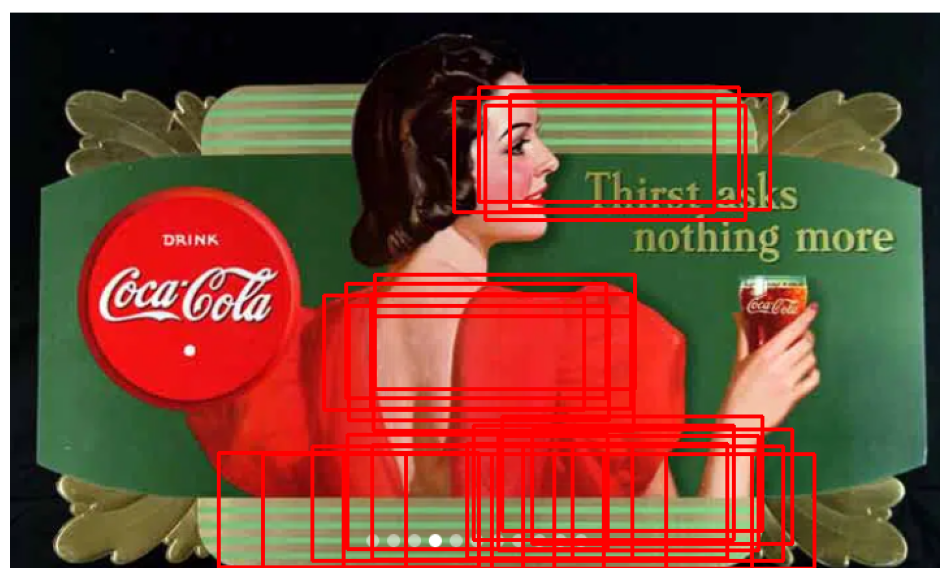

In [23]:
# mostramos nuevamente
plot_boxes(
    (xs_sorted[nms_kept], ys_sorted[nms_kept]),
    template_ds2,
    sample_img
)

Efectivamente, si bien ahora los tamaños son razonablemente parecidos al logo principal, no lo logra encontrar. Se especula que es por la diferencia antes observada entre color de la letra y color de fondo.

Pasamos entonces a detección de bordes.

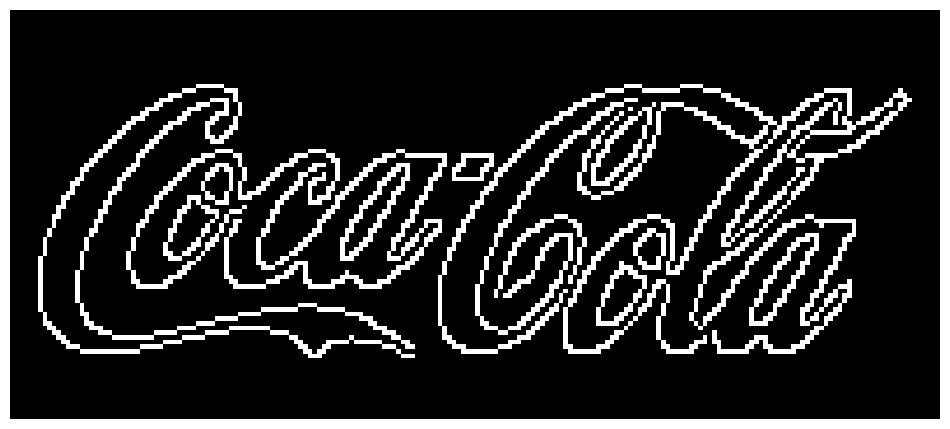

In [24]:
# trabajamos sobre la imagen downscaleada directamente
template_ds2_canny = cv.Canny(template_ds2, 50, 150)

sv.plot_image(template_ds2_canny)

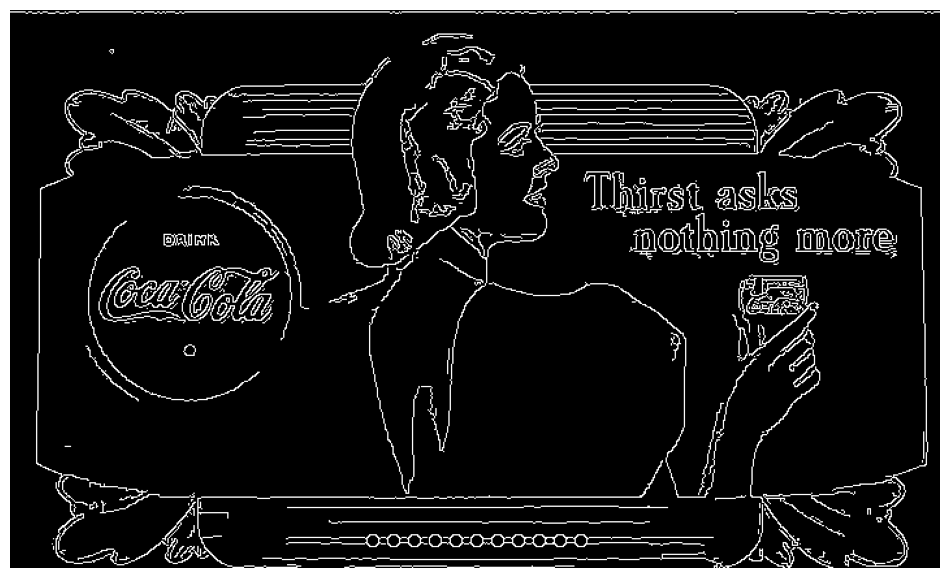

In [25]:
# ahora sobre la imagen original
sample_img_gs_canny = cv.Canny(sample_img_gs, 50, 150)

sv.plot_image(sample_img_gs_canny)

In [26]:
sample_img_gs_canny.shape

(429, 715)

In [27]:
sample_img_gs_canny[190:250,65:210].shape

(60, 145)

In [28]:
template_ds2_canny.shape

(88, 200)

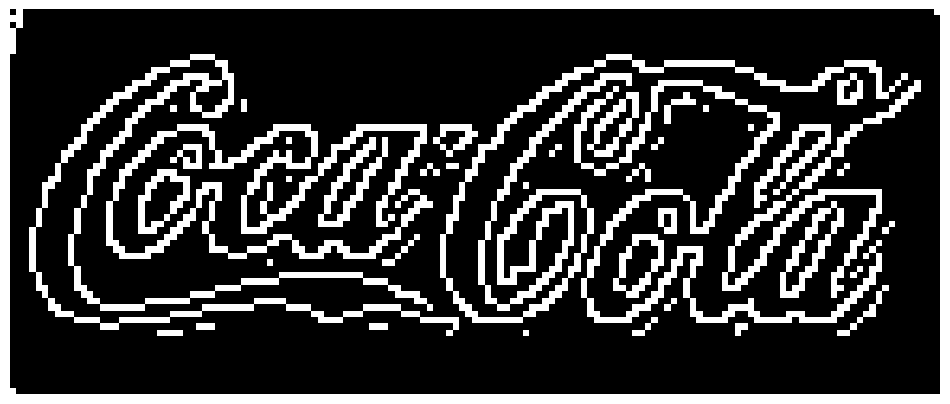

In [29]:
sv.plot_image(sample_img_gs_canny[190:250,65:210])

In [30]:
# a ver las nuevas detecciones...
res = cv.matchTemplate(
    sample_img_gs_canny, 
    template_ds2_canny, 
    method
)

res.min(), res.max()

(np.float32(1.0), np.float32(1.0))

No funciona! Pero ahora estamos seguros de que debería andar bien... probamos con otro método.

In [31]:
method = cv.TM_CCOEFF_NORMED # cv.TM_CCORR_NORMED

res = cv.matchTemplate(
    sample_img_gs_canny, 
    template_ds2_canny, 
    method
)

res.min(), res.max()

(np.float32(-0.08717976), np.float32(0.12273176))

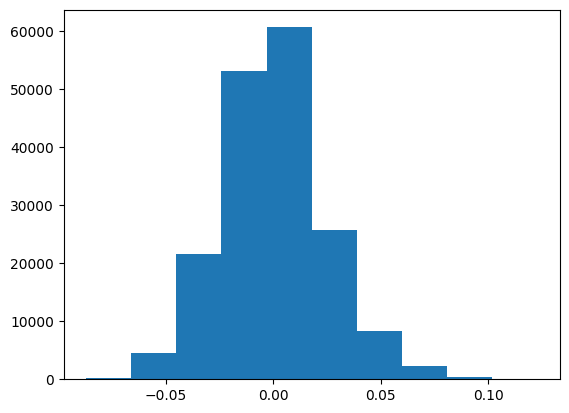

In [32]:
# vemos histograma de los scores para darnos una idea
plt.hist(res.flatten())
plt.show()

In [ ]:
# tiene buena pinta, seguimos
mask = cmp(res, 0.1, method)
ys, xs = np.where(mask)

print(len(ys))

scores = res[mask].flatten()

rank = np.argsort(scores)

if method not in MIN_BEST_METHODS:
    # best is highest instead
    rank = rank[::-1]

xs_sorted = xs[rank]
ys_sorted = ys[rank]

nms_kept = nms(
    x=xs_sorted,
    y=ys_sorted,
    template=template_ds2_canny,
    min_iou=0.7
)

print(len(nms_kept))

50
2


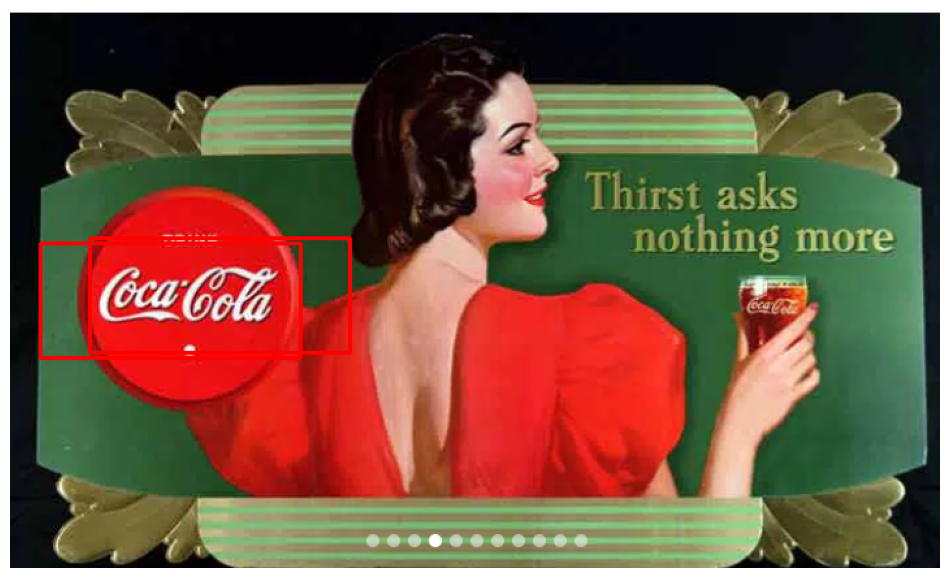

In [35]:
# mostramos las 2 cajas que quedaron
plot_boxes(
    (xs_sorted[nms_kept], ys_sorted[nms_kept]),
    template_ds2_canny,
    sample_img
)

Ahora sí anduvo bien, aunque las cajas que quedan deberían haber sido eliminadas durante NMS. Verificamos con el valor estándar de NMS que es 0.5.

In [ ]:
nms_kept = nms(
    x=xs_sorted,
    y=ys_sorted,
    template=template_ds2_canny,
    min_iou=0.5
)

print(len(nms_kept))

1


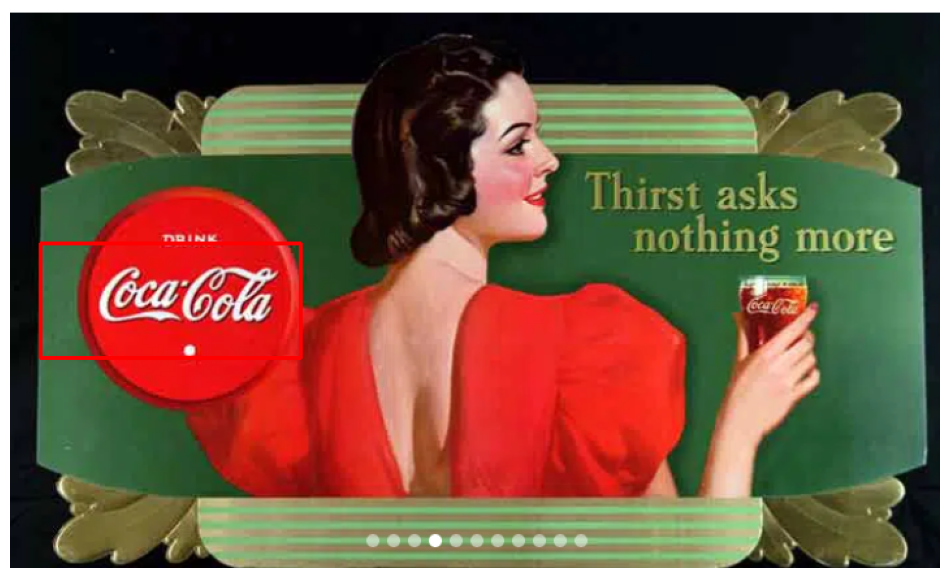

In [37]:
# ahora hay 1 sola caja, mostramos
plot_boxes(
    (xs_sorted[nms_kept], ys_sorted[nms_kept]),
    template_ds2_canny,
    sample_img
)

Ahora vemos si se puede detectar el texto más chico.

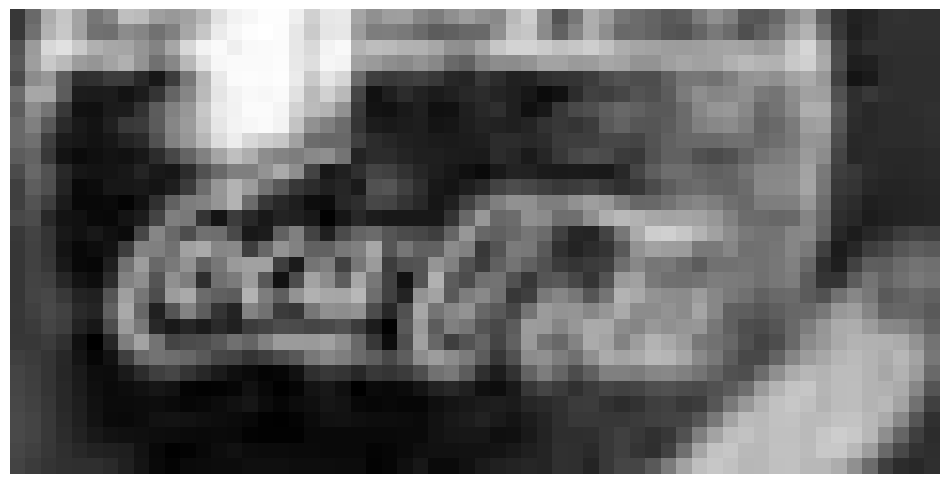

In [38]:
# crop manual
sv.plot_image(sample_img_gs[210:240,560:620])

In [39]:
# tamaño aproximado del texto?
sample_img_gs_canny[210:240,560:620].shape

(30, 60)

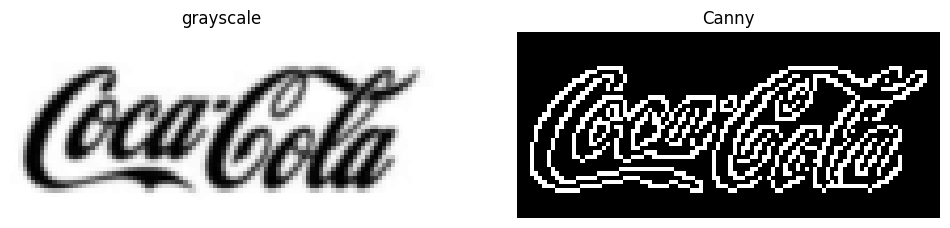

In [40]:
# downscaling
template_ds3 = cv.pyrDown(template_ds2)
template_ds3_canny = cv.Canny(template_ds3, 50, 150)

sv.plot_images_grid(
    [template_ds3, template_ds3_canny],
    [1,2],
    ['grayscale','Canny']
)

In [41]:
h3, w3 = template_ds3_canny.shape
h3, w3 

(44, 100)

In [42]:
# repetimos TM
res = cv.matchTemplate(
    sample_img_gs_canny, 
    template_ds3_canny, 
    method
)

res.min(), res.max()

(np.float32(-0.1305047), np.float32(0.17862903))

In [ ]:
# repetimos scoring, etc.
mask = cmp(res, 0.1, method)
ys, xs = np.where(mask)

print(len(ys))

scores = res[mask].flatten()

rank = np.argsort(scores)

if method not in MIN_BEST_METHODS:
    # best is highest instead
    rank = rank[::-1]

xs_sorted = xs[rank]
ys_sorted = ys[rank]

# ya directamente usamos el threshold standard
nms_kept = nms(
    x=xs_sorted,
    y=ys_sorted,
    template=template_ds3_canny,
    min_iou=0.5
)

print(len(nms_kept))

1115
38


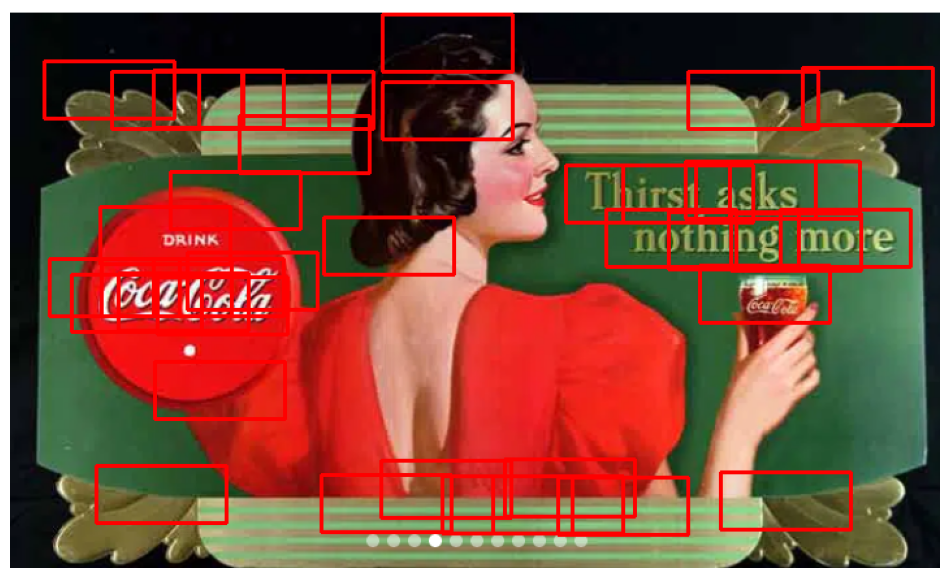

In [44]:
# quedaron muchas cajas, vemos qué pasó
plot_boxes(
    (xs_sorted[nms_kept], ys_sorted[nms_kept]),
    template_ds3_canny,
    sample_img
)

In [45]:
# a ver los top 20 scores
np.partition(scores, -20)[-20:]

array([0.14838764, 0.14913338, 0.14913341, 0.1500013 , 0.15000518,
       0.15278088, 0.15057005, 0.15316293, 0.15327342, 0.15336029,
       0.16082424, 0.1546047 , 0.15642844, 0.16152765, 0.16162199,
       0.17862903, 0.1718483 , 0.17135297, 0.16189961, 0.16718033],
      dtype=float32)

Ahora tenemos un problema con el threshold, que se acentúa si se considera que al menos 20 cajas de las 38 que sobreviven (casi todas falsos positivos) tienen un score mayor al match exacto de la resolución anterior.

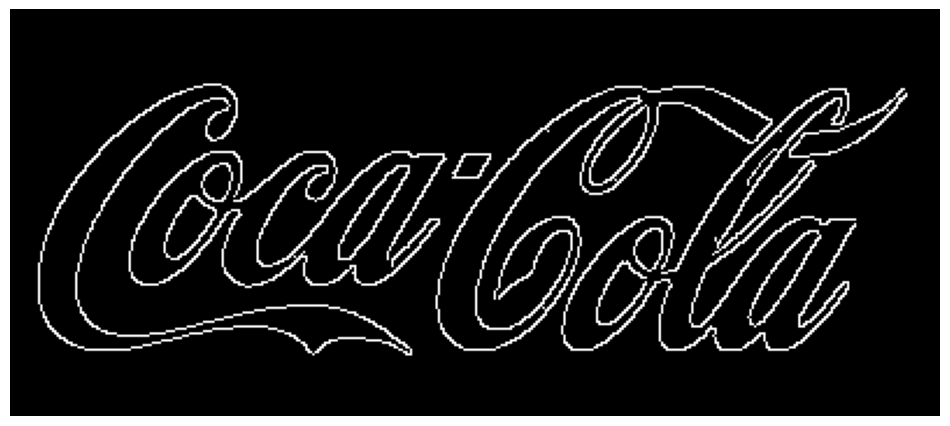

In [46]:
# funciona mejor si se usa primero Canny y luego pyrDown?
template_canny = cv.Canny(template,50,150)

sv.plot_image(template_canny)

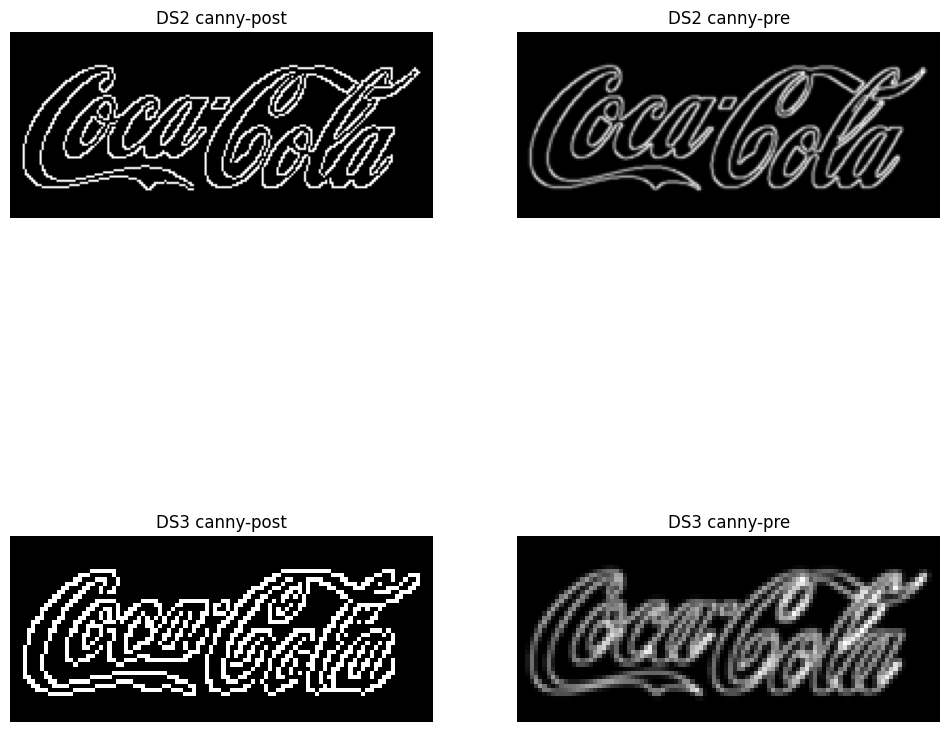

In [47]:
t2_canny_pre = cv.pyrDown(template_canny)
t3_canny_pre = cv.pyrDown(t2_canny_pre)

sv.plot_images_grid(
    [template_ds2_canny, t2_canny_pre,
     template_ds3_canny, t3_canny_pre],
    [2,2],
    ['DS2 canny-post','DS2 canny-pre',
     'DS3 canny-post','DS3 canny-pre'],
)

Tal vez así tenga menos spikes en los valores?

In [56]:
# vemos para nivel 2
res = cv.matchTemplate(
    sample_img_gs_canny, 
    t2_canny_pre, 
    method
)

res.min(), res.max()

(np.float32(-0.110935725), np.float32(0.15546831))

Para empezar el rango de scores es mayor.

Before NMS: 130
After NMS: 1


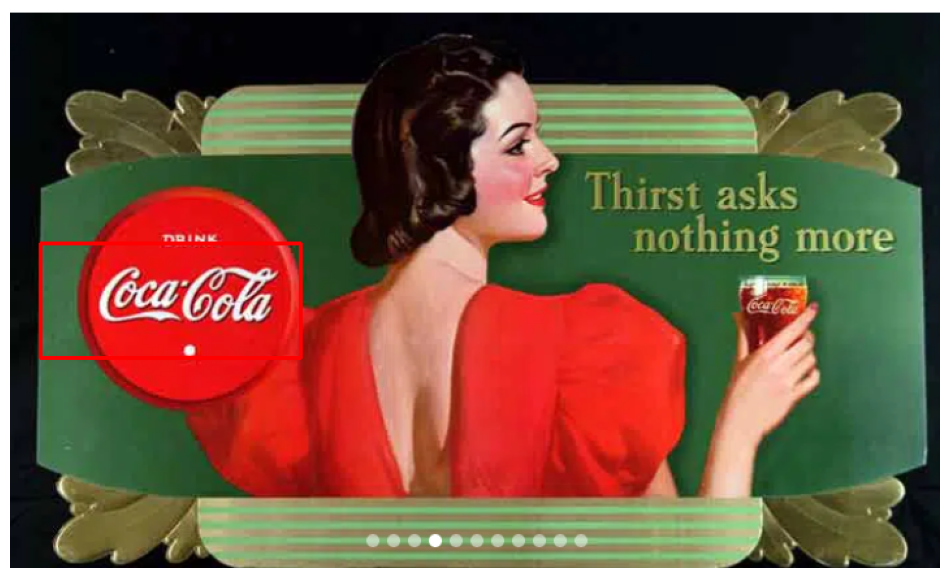

In [61]:
mask = cmp(res, 0.12, method)
ys, xs = np.where(mask)

print("Before NMS:",len(ys))

scores = res[mask].flatten()

rank = np.argsort(scores)

if method not in MIN_BEST_METHODS:
    # best is highest instead
    rank = rank[::-1]

xs_sorted = xs[rank]
ys_sorted = ys[rank]

# ya directamente usamos el threshold standard
nms_kept = nms(
    x=xs_sorted,
    y=ys_sorted,
    template=t2_canny_pre,
    min_iou=0.5
)

print("After NMS:",len(nms_kept))

plot_boxes(
    (xs_sorted[nms_kept], ys_sorted[nms_kept]),
    t2_canny_pre,
    sample_img
)

Detección correcta, nos movemos a la escala siguiente, que traía problemas.

In [62]:
res = cv.matchTemplate(
    sample_img_gs_canny, 
    t3_canny_pre, 
    method
)

res.min(), res.max()

(np.float32(-0.17805603), np.float32(0.2492352))

Otra vez rango mucho mayor de scores, con valores superiores a los de la escala de mayor resolución.

Before NMS: 3626
After NMS: 51


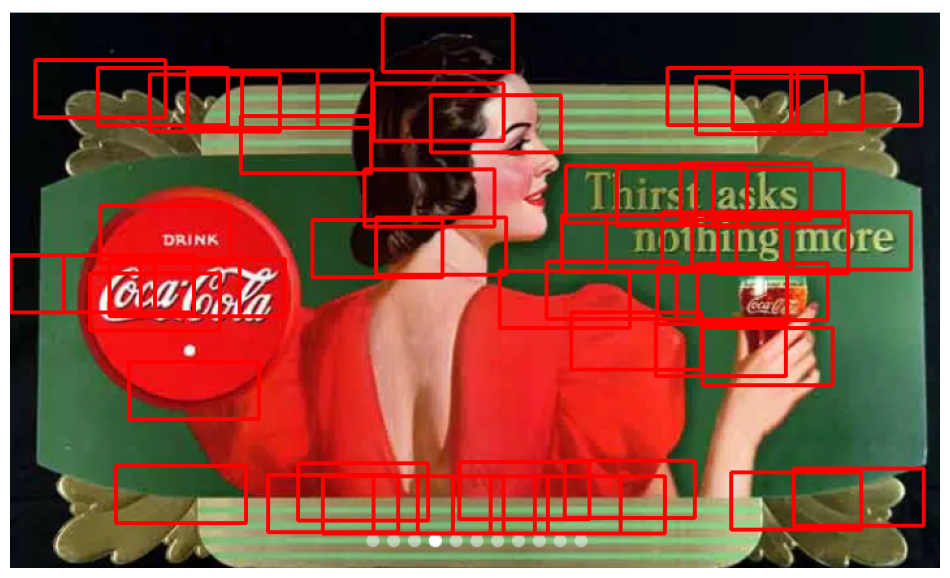

In [64]:
# a ver con el mismo threshold
mask = cmp(res, 0.12, method)
ys, xs = np.where(mask)

print("Before NMS:",len(ys))

scores = res[mask].flatten()

rank = np.argsort(scores)

if method not in MIN_BEST_METHODS:
    # best is highest instead
    rank = rank[::-1]

xs_sorted = xs[rank]
ys_sorted = ys[rank]

# ya directamente usamos el threshold standard
nms_kept = nms(
    x=xs_sorted,
    y=ys_sorted,
    template=t3_canny_pre,
    min_iou=0.5
)

print("After NMS:",len(nms_kept))

plot_boxes(
    (xs_sorted[nms_kept], ys_sorted[nms_kept]),
    t3_canny_pre,
    sample_img
)

Before NMS: 263
After NMS: 12


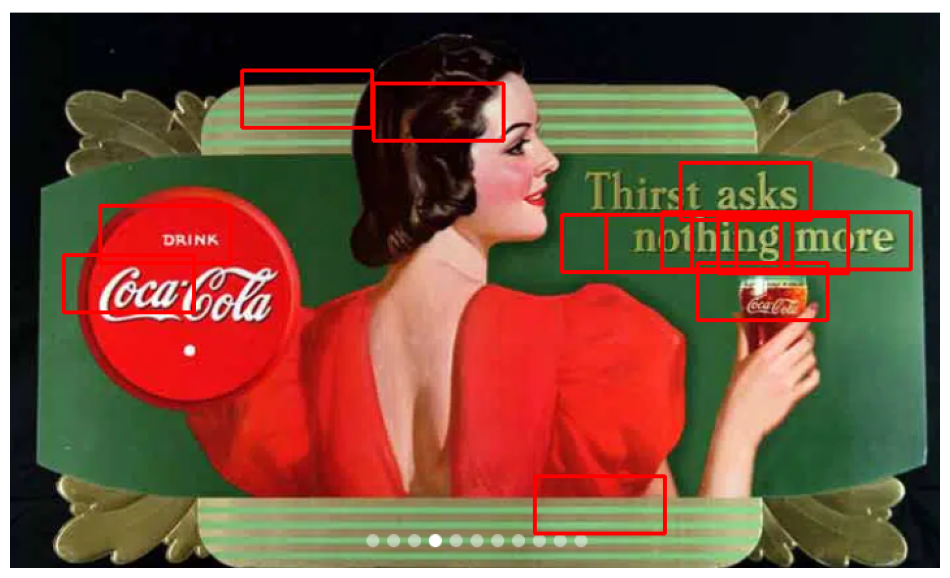

In [67]:
# es horrible! probamos un threshold más alto
mask = cmp(res, 0.17, method)
ys, xs = np.where(mask)

print("Before NMS:",len(ys))

scores = res[mask].flatten()

rank = np.argsort(scores)

if method not in MIN_BEST_METHODS:
    # best is highest instead
    rank = rank[::-1]

xs_sorted = xs[rank]
ys_sorted = ys[rank]

# ya directamente usamos el threshold standard
nms_kept = nms(
    x=xs_sorted,
    y=ys_sorted,
    template=t3_canny_pre,
    min_iou=0.5
)

print("After NMS:",len(nms_kept))

plot_boxes(
    (xs_sorted[nms_kept], ys_sorted[nms_kept]),
    t3_canny_pre,
    sample_img
)

Vemos qué pasa con un downscale más...

In [68]:
t4_canny_pre = cv.pyrDown(t3_canny_pre)
t4_canny_pre.shape

(22, 50)

In [69]:
res = cv.matchTemplate(
    sample_img_gs_canny, 
    t4_canny_pre, 
    method
)

res.min(), res.max()

(np.float32(-0.30061492), np.float32(0.323246))

Nuevamente, aumento del rango de scores.

Before NMS: 1270
After NMS: 77


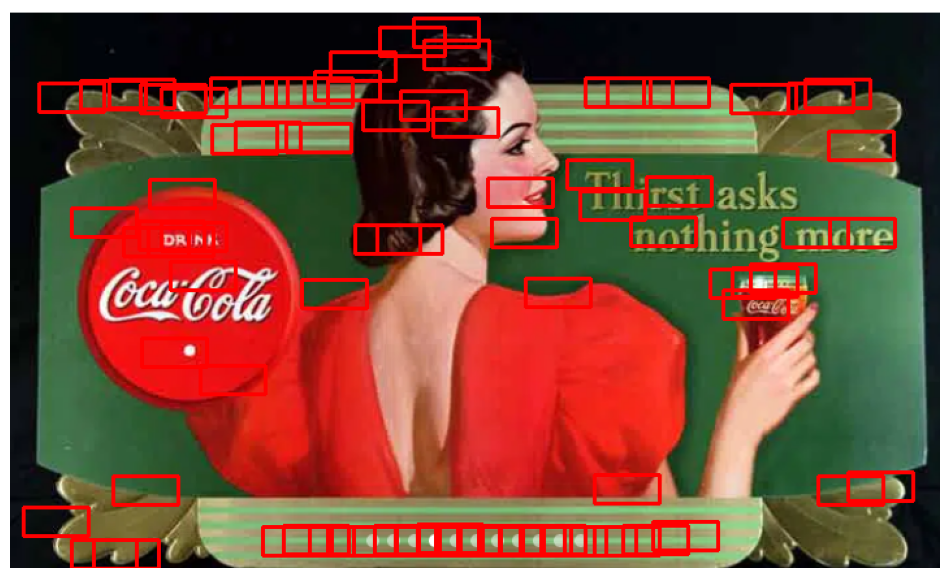

In [ ]:
# threshold un poco más alto
mask = cmp(res, 0.2, method)
ys, xs = np.where(mask)

print("Before NMS:",len(ys))

scores = res[mask].flatten()

rank = np.argsort(scores)

if method not in MIN_BEST_METHODS:
    # best is highest instead
    rank = rank[::-1]

xs_sorted = xs[rank]
ys_sorted = ys[rank]

# ya directamente usamos el threshold standard
nms_kept = nms(
    x=xs_sorted,
    y=ys_sorted,
    template=t4_canny_pre,
    min_iou=0.5
)

print("After NMS:",len(nms_kept))

plot_boxes(
    (xs_sorted[nms_kept], ys_sorted[nms_kept]),
    t4_canny_pre,
    sample_img
)